In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sns

Train dataset shape: (125973, 42)
Test dataset shape: (22544, 42)


<ipython-input-3-b7f7ada191a5>:53: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['class'] = train_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")
<ipython-input-3-b7f7ada191a5>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['class'] = test_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")


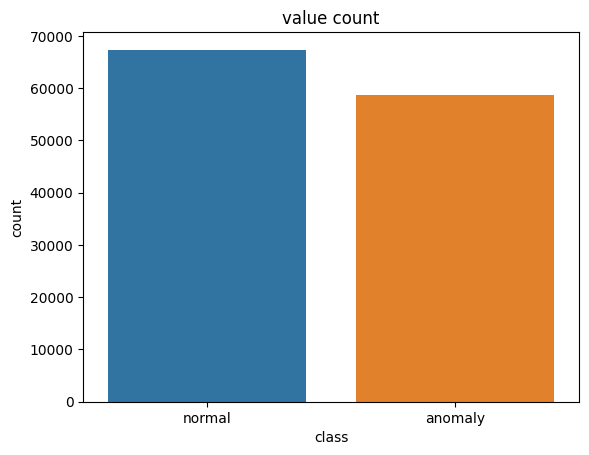

In [ ]:
CSV_HEADER = [
      "duration",
      "protocol_type",
      "service",
      "flag",
      "src_bytes",
      "dst_bytes",
      "land",
      "wrong_fragment",
      "urgent",
      "hot",
      "num_failed_logins",
      "logged_in",
      "num_compromised",
      "root_shell",
      "su_attempted",
      "num_root",
      "num_file_creations",
      "num_shells",
      "num_access_files",
      "num_outbound_cmds",
      "is_host_login",
      "is_guest_login",
      "count",
      "srv_count",
      "serror_rate",
      "srv_serror_rate",
      "rerror_rate",
      "srv_rerror_rate",
      "same_srv_rate",
      "diff_srv_rate",
      "srv_diff_host_rate",
      "dst_host_count",
      "dst_host_srv_count",
      "dst_host_same_srv_rate",
      "dst_host_diff_srv_rate",
      "dst_host_same_src_port_rate",
      "dst_host_srv_diff_host_rate",
      "dst_host_serror_rate",
      "dst_host_srv_serror_rate",
      "dst_host_rerror_rate",
      "dst_host_srv_rerror_rate",
      "class"
]


train_data = pd.read_csv("train.csv", header=None, names=CSV_HEADER)

test_data = pd.read_csv("test.csv", header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")
train_data['class'] = train_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")
test_data['class'] = test_data['class'].str.replace(r"^(.(?<!normal))*?$", "anomaly")

train_data['land'] = train_data['land'].astype(str)
test_data['land'] = test_data['land'].astype(str)

train_data['logged_in'] = train_data['logged_in'].astype(str)
test_data['logged_in'] = test_data['logged_in'].astype(str)

train_data['is_host_login'] = train_data['is_host_login'].astype(str)
test_data['is_host_login'] = test_data['is_host_login'].astype(str)

train_data['is_guest_login'] = train_data['is_guest_login'].astype(str)
test_data['is_guest_login'] = test_data['is_guest_login'].astype(str)

sns.countplot(
    x='class',
    data=train_data)
plt.title('value count')
plt.show()

train_data.protocol_type=train_data.protocol_type.astype('category').cat.codes
train_data.service=train_data.service.astype('category').cat.codes
train_data.flag=train_data.flag.astype('category').cat.codes
train_data.land=train_data.land.astype('category').cat.codes
train_data.logged_in=train_data.logged_in.astype('category').cat.codes
train_data.is_host_login=train_data.is_host_login.astype('category').cat.codes
train_data.is_guest_login=train_data.is_guest_login.astype('category').cat.codes

test_data.protocol_type=test_data.protocol_type.astype('category').cat.codes
test_data.service=test_data.service.astype('category').cat.codes
test_data.flag=test_data.flag.astype('category').cat.codes
test_data.land=test_data.land.astype('category').cat.codes
test_data.logged_in=test_data.logged_in.astype('category').cat.codes
test_data.is_host_login=test_data.is_host_login.astype('category').cat.codes
test_data.is_guest_login=test_data.is_guest_login.astype('category').cat.codes

## Removing outliers and duplicates

In [ ]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(train_data)
new_train_data = train_data[nonOutlierList]

nonOutlierList = Remove_Outlier_Indices(test_data)
new_test_data = test_data[nonOutlierList]

<ipython-input-4-c287b5c5fb36>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-4-c287b5c5fb36>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-4-c287b5c5fb36>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


## Merging train and test datasets

In [ ]:
frames = [new_train_data, new_test_data]
df = pd.concat(frames)
df = df.reset_index(drop=True)
df

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0              0              1       20     9        491          0     0   
1              0              2       44     9        146          0     0   
2              0              1       49     5          0          0     0   
3              0              1       24     9        232       8153     0   
4              0              1       24     9        199        420     0   
...          ...            ...      ...   ...        ...        ...   ...   
139899         0              0       14     9       1032          0     0   
139900         0              1       49     9        794        333     0   
139901         0              1       22     9        317        938     0   
139902         0              2       11     9         42         42     0   
139903         0              1       52     1          0          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                  25   
1                    0       0    0  ...                   1   
2                    0       0    0  ...                  26   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                 255   
...                ...     ...  ...  ...                 ...   
139899               0       0    0  ...                 255   
139900               0       0    0  ...                 141   
139901               0       0    0  ...                 255   
139902               0       0    0  ...                 252   
139903               0       0    0  ...                  21   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.17                    0.03   
1                         0.00                    0.60   
2                         0.10                    0.05   
3                         1.00                    0.00   
4                         1.00                    0.00   
...                        ...                     ...   
139899                    1.00                    0.00   
139900                    0.72                    0.06   
139901                    1.00                    0.00   
139902                    0.99                    0.01   
139903                    0.08                    0.03   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.17                         0.00   
1                              0.88                         0.00   
2                              0.00                         0.00   
3                              0.03                         0.04   
4                              0.00                         0.00   
...                             ...                          ...   
139899                         1.00                         0.00   
139900                         0.01                         0.01   
139901                         0.01                         0.01   
139902                         0.00                         0.00   
139903                         0.00                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.05   
1                       0.00                      0.00                  0.00   
2                       1.00                      1.00                  0.00   
3                       0.03                      0.01                  0.00   
4                       0.00                      0.00                  0.00   
...                      ...                       ...                   ...   
139899                  0.00                      0.00                  0.00   
139900                  0.01                      0.00                  0.00   
139901                  0.01                      0.00              

## Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = df.drop(['class'], axis=1)
Y = df["class"].astype('category').cat.codes
clf = RandomForestClassifier()
clf.fit(X, Y)
features = pd.Series(clf.feature_importances_, index=X.columns)
features.sort_values(ascending=False, inplace=True)
print(features.head(10))

src_bytes                 0.170986
dst_bytes                 0.136790
flag                      0.109430
diff_srv_rate             0.071831
logged_in                 0.052381
same_srv_rate             0.050228
dst_host_srv_count        0.044186
dst_host_diff_srv_rate    0.041677
dst_host_same_srv_rate    0.037905
service                   0.037454
dtype: float64


In [ ]:
fs = features.head(10).to_dict()
fs

{'src_bytes': 0.17098620255574568,
 'dst_bytes': 0.13679024895951913,
 'flag': 0.10942976466676348,
 'diff_srv_rate': 0.07183130071546076,
 'logged_in': 0.05238089001369002,
 'same_srv_rate': 0.05022756247592041,
 'dst_host_srv_count': 0.04418600834209949,
 'dst_host_diff_srv_rate': 0.04167726706300874,
 'dst_host_same_srv_rate': 0.037905206562235054,
 'service': 0.037454366858942253}

In [ ]:
columns = []
for k in fs:
  columns.append(str(k))
columns

['src_bytes',
 'dst_bytes',
 'flag',
 'diff_srv_rate',
 'logged_in',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_srv_rate',
 'service']

In [ ]:
X = df.drop(['class'], axis=1)
Y = df["class"].astype('category').cat.codes
principalDf = pd.DataFrame(data = X
             , columns = columns)
finalDf = pd.concat([principalDf, df["class"]], axis = 1)
finalDf

src_bytes  dst_bytes  flag  diff_srv_rate  logged_in  same_srv_rate  \
0             491          0     9           0.00          0           1.00   
1             146          0     9           0.15          0           0.08   
2               0          0     5           0.07          0           0.05   
3             232       8153     9           0.00          1           1.00   
4             199        420     9           0.00          1           1.00   
...           ...        ...   ...            ...        ...            ...   
139899       1032          0     9           0.00          0           1.00   
139900        794        333     9           0.00          1           1.00   
139901        317        938     9           0.00          1           1.00   
139902         42         42     9           0.00          0           1.00   
139903          0          0     1           1.00          0           0.25   

        dst_host_srv_count  dst_host_diff_srv_rate  dst_host_same_srv_rate  \
0                       25                    0.03                    0.17   
1                        1                    0.60                    0.00   
2                       26                    0.05                    0.10   
3                      255                    0.00                    1.00   
4                      255                    0.00                    1.00   
...                    ...                     ...                     ...   
139899                 255                    0.00                    1.00   
139900                 141                    0.06                    0.72   
139901                 255                    0.00                    1.00   
139902                 252                    0.01                    0.99   
139903                  21                    0.03                    0.08   

        service    class  
0            20   normal  
1            44   normal  
2            49  anomaly  
3            24   normal  
4            24   normal  
...         ...      ...  
139899       14  anomaly  
139900       49   normal  
139901       22   normal  
139902       11   normal  
139903       52  anomaly  

[139904 rows x 11 columns]

# Model

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append("class")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "class"
# A list of the labels of the target features.
TARGET_LABELS = ["normal", "anomaly"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
820/820 [==============================] - 76s 44ms/step - loss: 0.2196 - sparse_categorical_accuracy: 0.9087
Epoch 2/10
820/820 [==============================] - 18s 22ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9303
Epoch 3/10
820/820 [==============================] - 16s 20ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9361
Epoch 4/10
820/820 [==============================] - 18s 22ms/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9392
Epoch 5/10
820/820 [==============================] - 17s 21ms/step - loss: 0.1336 - sparse_categorical_accuracy: 0.9417
Epoch 6/10
820/820 [==============================] - 21s 25ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9439
Epoch 7/10
820/820 [==============================] - 18s 22ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.9454
Epoch 8/10
820/820 [==============================] - 17s 21ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.9464
Epoc

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('normal', 0,inplace=True)
data['target'].replace('anomaly', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))


274/274 [==============================] - 5s 9ms/step
[[0.92530258 0.02028617]
 [0.07469742 0.97971383]]
ACC: 0.9525082065813029
PR: 0.9785465208664409
TPR: 0.9253025816840683
FPR: 0.02028616852146264
F1Score: 0.9511800287561489


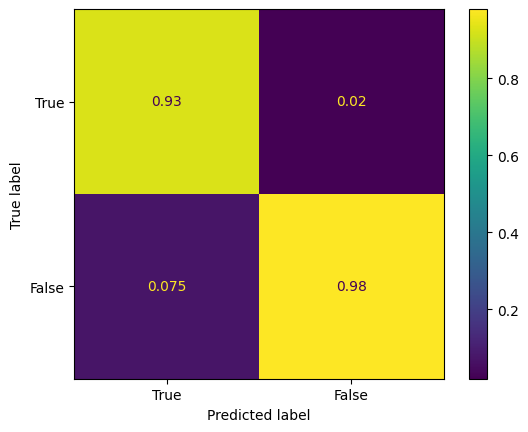

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()

## CISIDS2017

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import os

path = r'C:\DRO\DCL_rawdata_files' # use your path
all_files = glob.glob(os.path.join(path , "/content/drive/MyDrive/datasets/CISIDS2017/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
column_headers = list(frame.columns.values)
column_headers

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' P

In [ ]:
frame[' Label'] = frame[' Label'].str.replace(r"^(.(?<!BENIGN))*?$", "ANOMALY")

<ipython-input-4-fd8f3e1f0b2e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  frame[' Label'] = frame[' Label'].str.replace(r"^(.(?<!BENIGN))*?$", "ANOMALY")


In [ ]:
CSV_HEADER = column_headers

In [ ]:
df = frame

In [ ]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(df)
new_data = df[nonOutlierList]



<ipython-input-7-131013cf66a1>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-7-131013cf66a1>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-7-131013cf66a1>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


In [ ]:
df = new_data
df = df.reset_index(drop=True)
del new_data
del nonOutlierList
del li
del frame

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = df.drop([' Label'], axis=1)
Y = df[" Label"].astype('category').cat.codes
clf = RandomForestClassifier()
clf.fit(X, Y)
features = pd.Series(clf.feature_importances_, index=X.columns)
features.sort_values(ascending=False, inplace=True)
print(features.head(10))

 Packet Length Variance        0.081247
 Packet Length Std             0.064861
 Packet Length Mean            0.056147
 Average Packet Size           0.050787
 Destination Port              0.049960
Bwd Packet Length Max          0.043204
 Avg Bwd Segment Size          0.037427
Total Length of Fwd Packets    0.034475
 Bwd Packet Length Mean        0.032600
Init_Win_bytes_forward         0.030282
dtype: float64


In [ ]:
fs = features.head(10).to_dict()
fs

{' Packet Length Variance': 0.08124749509423052,
 ' Packet Length Std': 0.06486087933746576,
 ' Packet Length Mean': 0.05614707208016595,
 ' Average Packet Size': 0.050786574411919236,
 ' Destination Port': 0.049960097719106485,
 'Bwd Packet Length Max': 0.04320449616955384,
 ' Avg Bwd Segment Size': 0.037427049333999665,
 'Total Length of Fwd Packets': 0.0344753595505703,
 ' Bwd Packet Length Mean': 0.03260012604646854,
 'Init_Win_bytes_forward': 0.03028173100385773}

In [ ]:
columns = []
for k in fs:
  columns.append(str(k))
columns

[' Packet Length Variance',
 ' Packet Length Std',
 ' Packet Length Mean',
 ' Average Packet Size',
 ' Destination Port',
 'Bwd Packet Length Max',
 ' Avg Bwd Segment Size',
 'Total Length of Fwd Packets',
 ' Bwd Packet Length Mean',
 'Init_Win_bytes_forward']

In [ ]:
principalDf = pd.DataFrame(data = X
             , columns = columns)
finalDf = pd.concat([principalDf, df[" Label"]], axis = 1)
finalDf

Packet Length Variance   Packet Length Std   Packet Length Mean  \
0                       0.000000            0.000000             6.000000   
1                       0.000000            0.000000             6.000000   
2                       0.000000            0.000000             6.000000   
3                       0.000000            0.000000             6.000000   
4                       0.000000            0.000000             6.000000   
...                          ...                 ...                  ...   
2539413               548.571429           23.421602            41.714286   
2539414              5796.300000           76.133435            97.600000   
2539415               267.333333           16.350331            17.000000   
2539416              1792.000000           42.332021            53.333333   
2539417              1037.142857           32.204702            65.857143   

          Average Packet Size   Destination Port  Bwd Packet Length Max  \
0                    9.000000              54865                      0   
1                    9.000000              55054                      6   
2                    9.000000              55055                      6   
3                    9.000000              46236                      6   
4                    9.000000              54863                      0   
...                       ...                ...                    ...   
2539413             48.666667                 53                     76   
2539414            122.000000                 53                    181   
2539415             22.666667              58030                      6   
2539416             60.000000                 53                    128   
2539417             76.833333                 53                    113   

          Avg Bwd Segment Size  Total Length of Fwd Packets  \
0                          0.0                           12   
1                          6.0                            6   
2                          6.0                            6   
3                          6.0                            6   
4                          0.0                           12   
...                        ...                          ...   
2539413                   76.0                          112   
2539414                  181.0                           84   
2539415                    6.0                           31   
2539416                  128.0                          192   
2539417                  113.0                          188   

          Bwd Packet Length Mean  Init_Win_bytes_forward   Label  
0                            0.0                      33  BENIGN  
1                            6.0                      29  BENIGN  
2                            6.0                      29  BENIGN  
3                            6.0                      31  BENIGN  
4                            0.0                      32  BENIGN  
...                          ...                     ...     ...  
2539413                     76.0                      -1  BENIGN  
2539414                    181.0                      -1  BENIGN  
2539415                      6.0                    1006  BENIGN  
2539416                    128.0                      -1  BENIGN  
2539417                    113.0                      -1  BENIGN  

[2539418 rows x 11 columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
del finalDf
del principalDf
del train_data
del test_data
del clf
del X
del Y

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sns

CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append(" Label")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = " Label"
# A list of the labels of the target features.
TARGET_LABELS = ["BENIGN", "ANOMALY"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
14880/14880 [==============================] - 474s 29ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.8957
Epoch 2/10
14880/14880 [==============================] - 354s 24ms/step - loss: 0.1903 - sparse_categorical_accuracy: 0.9018
Epoch 3/10
14880/14880 [==============================] - 353s 24ms/step - loss: 0.1861 - sparse_categorical_accuracy: 0.9025
Epoch 4/10
14880/14880 [==============================] - 379s 25ms/step - loss: 0.1827 - sparse_categorical_accuracy: 0.9029
Epoch 5/10
14880/14880 [==============================] - 375s 25ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9032
Epoch 6/10
14880/14880 [==============================] - 378s 25ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9037
Epoch 7/10
14880/14880 [==============================] - 373s 25ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9039
Epoch 8/10
14880/14880 [==============================] - 374s 25ms/step - loss: 0.1780 - 

4960/4960 [==============================] - 59s 12ms/step
[[0.90649143 0.090948  ]
 [0.09350857 0.909052  ]]
ACC: 0.9077717104763482
PR: 0.9088185189042338
TPR: 0.906491425484989
FPR: 0.09094800453229258
F1Score: 0.9076534806135734


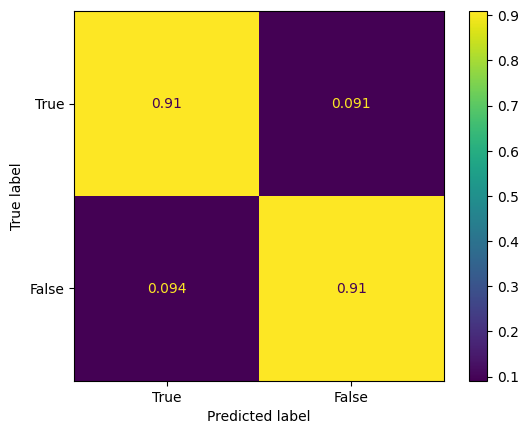

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('BENIGN', 0,inplace=True)
data['target'].replace('ANOMALY', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()

## UNSW-NB15

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CSV_HEADER = [
"srcip",
"sport",
"dstip",
"dsport",
"proto",
"state",
"dur",
"sbytes",
"dbytes",
"sttl",
"dttl",
"sloss",
"dloss",
"service",
"Sload",
"Dload",
"Spkts",
"Dpkts",
"swin",
"dwin",
"stcpb",
"dtcpb",
"smeansz",
"dmeansz",
"trans_depth",
"res_bdy_len",
"Sjit",
"Djit",
"Stime",
"Ltime",
"Sintpkt",
"Dintpkt",
"tcprtt",
"synack",
"ackdat",
"is_sm_ips_ports",
"ct_state_ttl",
"ct_flw_http_mthd",
"is_ftp_login",
"ct_ftp_cmd",
"ct_srv_src",
"ct_srv_dst",
"ct_dst_ltm",
"ct_src_ ltm",
"ct_src_dport_ltm",
"ct_dst_sport_ltm",
"ct_dst_src_ltm",
"attack_cat",
"Label"
]

In [ ]:
import pandas as pd
import glob
import os

path = r'C:\DRO\DCL_rawdata_files' # use your path
all_files = glob.glob(os.path.join(path , "/content/drive/MyDrive/datasets/UNSW-NB15/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=CSV_HEADER,low_memory=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
pd.set_option('display.max_columns', None)
frame

srcip  sport          dstip dsport proto state       dur  \
0        59.166.0.9   7045  149.171.126.7     25   tcp   FIN  0.201886   
1        59.166.0.9   9685  149.171.126.2     80   tcp   FIN  5.864748   
2        59.166.0.2   1421  149.171.126.4     53   udp   CON  0.001391   
3        59.166.0.2  21553  149.171.126.2     25   tcp   FIN  0.053948   
4        59.166.0.8  45212  149.171.126.4     53   udp   CON  0.000953   
...             ...    ...            ...    ...   ...   ...       ...   
2540042  59.166.0.8  12520  149.171.126.6  31010   tcp   FIN  0.020383   
2540043  59.166.0.0  18895  149.171.126.9     80   tcp   FIN  1.402957   
2540044  59.166.0.0  30103  149.171.126.5   5190   tcp   FIN  0.007108   
2540045  59.166.0.6  30388  149.171.126.5    111   udp   CON  0.004435   
2540046  59.166.0.0   6055  149.171.126.5  54145   tcp   FIN  0.072974   

         sbytes   dbytes  sttl  dttl  sloss  dloss service         Sload  \
0         37552     3380    31    29     18      8    smtp  1.459438e+06   
1         19410  1087890    31    29      2    370    http  2.640454e+04   
2           146      178    31    29      0      0     dns  4.198418e+05   
3         37812     3380    31    29     19      8    smtp  5.503374e+06   
4           146      178    31    29      0      0     dns  6.128017e+05   
...         ...      ...   ...   ...    ...    ...     ...           ...   
2540042     320     1874    31    29      1      2       -  1.047932e+05   
2540043   19410  1087890    31    29      2    370    http  1.103783e+05   
2540044    2158     2464    31    29      6      6       -  2.328644e+06   
2540045     568      304    31    29      0      0       -  7.684329e+05   
2540046    4238    60788    31    29      7     30       -  4.582454e+05   

                Dload  Spkts  Dpkts  swin  dwin       stcpb       dtcpb  \
0        1.307669e+05     52     42   255   255  1422136554  3572668484   
1        1.481983e+06    364    746   255   255   389619597   394688654   
2        5.118620e+05      2      2     0     0           0           0   
3        4.893601e+05     54     42   255   255  4047523379  1903327524   
4        7.471144e+05      2      2     0     0           0           0   
...               ...    ...    ...   ...   ...         ...         ...   
2540042  6.436736e+05      6      8   255   255  3208686479  3225486168   
2540043  6.195098e+06    364    746   255   255   283296697  2429736754   
2540044  2.658413e+06     24     24   255   255   703293844  2848960529   
2540045  4.112740e+05      4      4     0     0           0           0   
2540046  6.571546e+06     72     72   255   255  1003293149  1003585034   

         smeansz  dmeansz  trans_depth  res_bdy_len         Sjit        Djit  \
0            722       80            0            0   456.043567   15.530109   
1             53     1458            1            0  1031.366423  690.219581   
2             73       89            0            0     0.000000    0.000000   
3            700       80            0            0    65.909688    3.155258   
4             73       89            0            0     0.000000    0.000000   
...          ...      ...          ...          ...          ...         ...   
2540042       53      234            0            0   212.810729    3.079195   
2540043       53     1458            1         3924   203.808900  114.173588   
2540044       90      103            0            0    17.627831    0.432619   
2540045      142       76            0            0     1.638604    1.390643   
2540046       59      844            0            0    62.045310   61.899776   

              Stime       Ltime    Sintpkt   Dintpkt    tcprtt    synack  \
0        1424250009  1424250009   3.943843  4.912488  0.000590  0.000473   
1        1424250003  1424250009  16.155447  7.871279  0.000771  0.000638   
2        1424250009  1424250009   0.009000  0.002000  0.000000  0.000000   
3        1424250009  1424250009   1.011547  1.

In [ ]:
frame.srcip = frame.srcip.astype('category').cat.codes
frame.dstip = frame.dstip.astype('category').cat.codes
frame.proto = frame.proto.astype('category').cat.codes
frame.state = frame.state.astype('category').cat.codes
frame.service = frame.service.astype('category').cat.codes
frame.ct_flw_http_mthd = frame.ct_flw_http_mthd.astype('category').cat.codes
frame.is_ftp_login = frame.is_ftp_login.astype('category').cat.codes
frame.ct_ftp_cmd = frame.ct_ftp_cmd.astype('category').cat.codes
frame['Label'] = frame['Label'].astype(str)
frame['Label'] = frame['Label'].str.replace("1", "anomaly")
frame['Label'] = frame['Label'].str.replace("0", "normal")
frame = frame.drop('attack_cat', axis=1)
frame

srcip  sport  dstip dsport  proto  state       dur  sbytes   dbytes  \
0           42   7045     25     25    114      5  0.201886   37552     3380   
1           42   9685     20     80    114      5  5.864748   19410  1087890   
2           35   1421     22     53    120      2  0.001391     146      178   
3           35  21553     20     25    114      5  0.053948   37812     3380   
4           41  45212     22     53    120      2  0.000953     146      178   
...        ...    ...    ...    ...    ...    ...       ...     ...      ...   
2540042     41  12520     24  31010    114      5  0.020383     320     1874   
2540043     33  18895     27     80    114      5  1.402957   19410  1087890   
2540044     33  30103     23   5190    114      5  0.007108    2158     2464   
2540045     39  30388     23    111    120      2  0.004435     568      304   
2540046     33   6055     23  54145    114      5  0.072974    4238    60788   

         sttl  dttl  sloss  dloss  service         Sload         Dload  Spkts  \
0          31    29     18      8        9  1.459438e+06  1.307669e+05     52   
1          31    29      2    370        5  2.640454e+04  1.481983e+06    364   
2          31    29      0      0        2  4.198418e+05  5.118620e+05      2   
3          31    29     19      8        9  5.503374e+06  4.893601e+05     54   
4          31    29      0      0        2  6.128017e+05  7.471144e+05      2   
...       ...   ...    ...    ...      ...           ...           ...    ...   
2540042    31    29      1      2        0  1.047932e+05  6.436736e+05      6   
2540043    31    29      2    370        5  1.103783e+05  6.195098e+06    364   
2540044    31    29      6      6        0  2.328644e+06  2.658413e+06     24   
2540045    31    29      0      0        0  7.684329e+05  4.112740e+05      4   
2540046    31    29      7     30        0  4.582454e+05  6.571546e+06     72   

         Dpkts  swin  dwin       stcpb       dtcpb  smeansz  dmeansz  \
0           42   255   255  1422136554  3572668484      722       80   
1          746   255   255   389619597   394688654       53     1458   
2            2     0     0           0           0       73       89   
3           42   255   255  4047523379  1903327524      700       80   
4            2     0     0           0           0       73       89   
...        ...   ...   ...         ...         ...      ...      ...   
2540042      8   255   255  3208686479  3225486168       53      234   
2540043    746   255   255   283296697  2429736754       53     1458   
2540044     24   255   255   703293844  2848960529       90      103   
2540045      4     0     0           0           0      142       76   
2540046     72   255   255  1003293149  1003585034       59      844   

         trans_depth  res_bdy_len         Sjit        Djit       Stime  \
0                  0            0   456.043567   15.530109  1424250009   
1                  1            0  1031.366423  690.219581  1424250003   
2                  0            0     0.000000    0.000000  1424250009   
3                  0            0    65.909688    3.155258  1424250009   
4                  0            0     0.000000    0.000000  1424250009   
...              ...          ...          ...         ...         ...   
2540042            0            0   212.810729    3.079195  1421955842   
2540043            1         3924   203.808900  114.173588  1421955841   
2540044            0            0    17.627831    0.432619  1421955842   
2540045            0            0     1.638604    1.390643  1421955842   
2540046            0            0    62.045310   61.899776  1421955842   

              Ltime    Sintpkt   Dintpkt    tcprtt    synack    ackdat  \
0        1424250009   3.943843  4.912488  0.000590  0.000473  0.000117   
1        1424250009  16.155447  7.871279  0.000771  0.000638  0.000133   
2        1424250009   0.009000  0.002000  0.000000  0.000000  0.000000   
3        1424250009   1.0

In [ ]:
column_headers = list(frame.columns.values)
column_headers

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'Sload',
 'Dload',
 'Spkts',
 'Dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'Sjit',
 'Djit',
 'Stime',
 'Ltime',
 'Sintpkt',
 'Dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'Label']

In [ ]:
CSV_HEADER = column_headers
df = frame
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)
    return trueList

nonOutlierList = Remove_Outlier_Indices(df)
new_data = df[nonOutlierList]

df = new_data
df = df.reset_index(drop=True)
del new_data
del nonOutlierList
del li
del frame
import gc
gc.collect()

<ipython-input-7-033f6da543bf>:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.02)
<ipython-input-7-033f6da543bf>:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.98)
<ipython-input-7-033f6da543bf>:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)


49

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = df.drop(['Label'], axis=1)
Y = df["Label"].astype('category').cat.codes
clf = RandomForestClassifier()
clf.fit(X, Y)
features = pd.Series(clf.feature_importances_, index=X.columns)
features.sort_values(ascending=False, inplace=True)
print(features.head(10))

ct_state_ttl    0.204888
sttl            0.152128
srcip           0.092287
sbytes          0.076845
smeansz         0.073014
dttl            0.051160
dstip           0.041404
dmeansz         0.034131
Dload           0.030871
Dpkts           0.027830
dtype: float64


In [ ]:
fs = features.head(10).to_dict()
fs

{'ct_state_ttl': 0.20488763325717038,
 'sttl': 0.1521284631007735,
 'srcip': 0.09228731567941095,
 'sbytes': 0.07684506148216279,
 'smeansz': 0.07301405337046245,
 'dttl': 0.05116042357030089,
 'dstip': 0.04140361232353322,
 'dmeansz': 0.03413087150829379,
 'Dload': 0.030870500320368942,
 'Dpkts': 0.02783016435570764}

In [ ]:
columns = []
for k in fs:
  columns.append(str(k))
columns

['ct_state_ttl',
 'sttl',
 'srcip',
 'sbytes',
 'smeansz',
 'dttl',
 'dstip',
 'dmeansz',
 'Dload',
 'Dpkts']

In [ ]:
principalDf = pd.DataFrame(data = X
             , columns = columns)
finalDf = pd.concat([principalDf, df["Label"]], axis = 1)
finalDf

ct_state_ttl  sttl  srcip  sbytes  smeansz  dttl  dstip  dmeansz  \
0                   0    31     42   37552      722    29     25       80   
1                   0    31     42   19410       53    29     20     1458   
2                   0    31     35     146       73    29     22       89   
3                   0    31     35   37812      700    29     20       80   
4                   0    31     41     146       73    29     22       89   
...               ...   ...    ...     ...      ...   ...    ...      ...   
2438669             0    31     41     320       53    29     24      234   
2438670             0    31     33   19410       53    29     27     1458   
2438671             0    31     33    2158       90    29     23      103   
2438672             0    31     39     568      142    29     23       76   
2438673             0    31     33    4238       59    29     23      844   

                Dload  Dpkts   Label  
0        1.307669e+05     42  normal  
1        1.481983e+06    746  normal  
2        5.118620e+05      2  normal  
3        4.893601e+05     42  normal  
4        7.471144e+05      2  normal  
...               ...    ...     ...  
2438669  6.436736e+05      8  normal  
2438670  6.195098e+06    746  normal  
2438671  2.658413e+06     24  normal  
2438672  4.112740e+05      4  normal  
2438673  6.571546e+06     72  normal  

[2438674 rows x 11 columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(finalDf, test_size=0.25)
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
del finalDf
del principalDf
del train_data
del test_data
del clf
del X
del Y

In [ ]:
CSV_HEADER = []
for x in columns:
  CSV_HEADER.append(x)
CSV_HEADER.append("Label")

# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = columns
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}
# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "Label"
# A list of the labels of the target features.
TARGET_LABELS = ["normal", "anomaly"]

from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            #print(vocabulary)
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs
learning_rate = 0.01
batch_size = 128
num_epochs = 10


def run_experiment(model):

    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()],
    )
    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    print("Evaluating the model on the test data...")
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return model

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()

finalModel = run_experiment(forest_model)

Start training the model...
Epoch 1/10
14290/14290 [==============================] - 467s 31ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9877
Epoch 2/10
14290/14290 [==============================] - 400s 28ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9881
Epoch 3/10
14290/14290 [==============================] - 375s 26ms/step - loss: 0.0235 - sparse_categorical_accuracy: 0.9881
Epoch 4/10
14290/14290 [==============================] - 377s 26ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9885
Epoch 5/10
14290/14290 [==============================] - 374s 26ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9887
Epoch 6/10
14290/14290 [==============================] - 364s 25ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9887
Epoch 7/10
14290/14290 [==============================] - 376s 26ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9887
Epoch 8/10
14290/14290 [==============================] - 373s 26ms/step - loss: 0.0229 - 

4764/4764 [==============================] - 64s 13ms/step
[[9.99784982e-01 8.43356819e-02]
 [2.15017664e-04 9.15664318e-01]]
ACC: 0.957724650201963
PR: 0.9222082147198775
TPR: 0.9997849823364876
FPR: 0.08433568193256165
F1Score: 0.9594309959851927


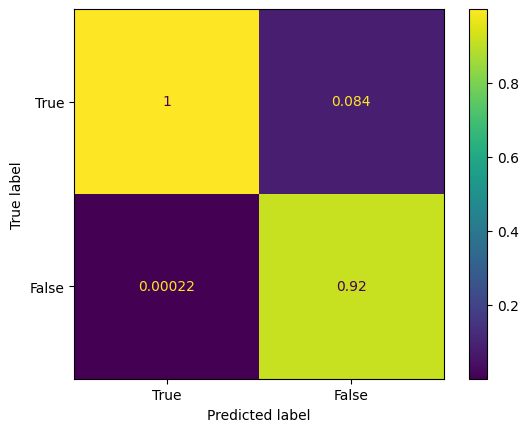

In [ ]:
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
colnames=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'target']
data = pd.read_csv("test_data.csv", names=colnames, header=None)
data['target'].replace('normal', 0,inplace=True)
data['target'].replace('anomaly', 1,inplace=True)
y_test = data['target'].values  # as a numpy array
from sklearn.metrics import confusion_matrix
y_prediction = finalModel.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
TP = result[0][0]
FP = result[0][1]
TN = result[1][1]
FN = result[1][0]
ACC = (TP+TN)/(TP+TN+FP+FN)
PR = TP/(TP+FP) #precision
TPR = TP/(TP+FN) #Recall or True positive rate
FPR = FP/(FP+TN)
F1Score = 2*(PR*TPR)/(PR+TPR)
print("ACC: " + str(ACC))
print("PR: " + str(PR))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("F1Score: " + str(F1Score))
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [True, False])

cm_display.plot()
plt.show()